In [2]:
!kaggle datasets download -d marqui"s03/bdd100k"

Dataset URL: https://www.kaggle.com/datasets/marquis03/bdd100k
License(s): apache-2.0
100% 5.38G/5.38G [05:54<00:00, 20.0MB/s]
100% 5.38G/5.38G [05:54<00:00, 16.3MB/s]


In [3]:
import zipfile
# Replace 'path/to/your/zipfile.zip' with the actual path to your ZIP file
with zipfile.ZipFile('/content/bdd100k.zip', 'r') as zip_ref:
    zip_ref.extractall()


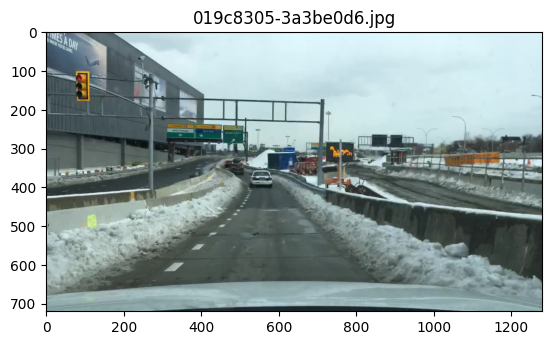

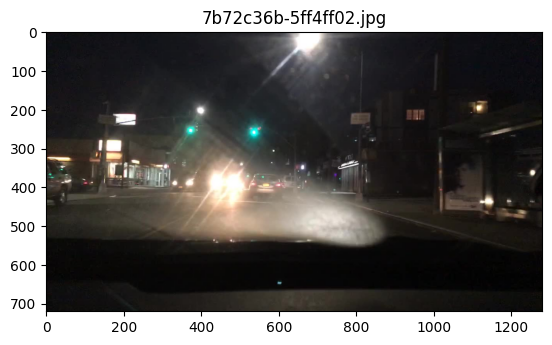

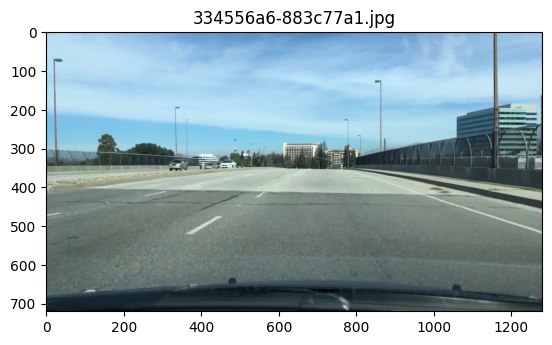

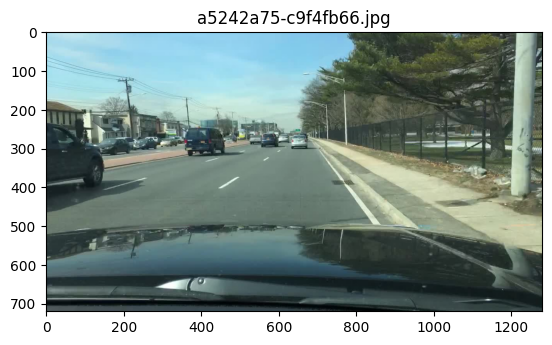

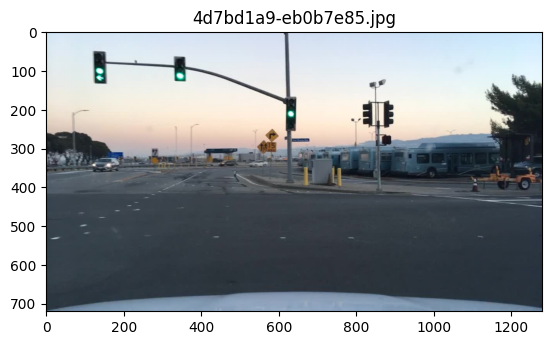

In [4]:
import os
import matplotlib.pyplot as plt

# Replace 'path/to/your/images/directory' with the actual path to your images directory
image_dir = '/content/train/images'

# Get a list of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]  # Assuming JPG format

# Display the first few images
for i in range(5):  # Display the first 5 images
    image_path = os.path.join(image_dir, image_files[i])
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(image_files[i])
    plt.show()

Latent representation using vit

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


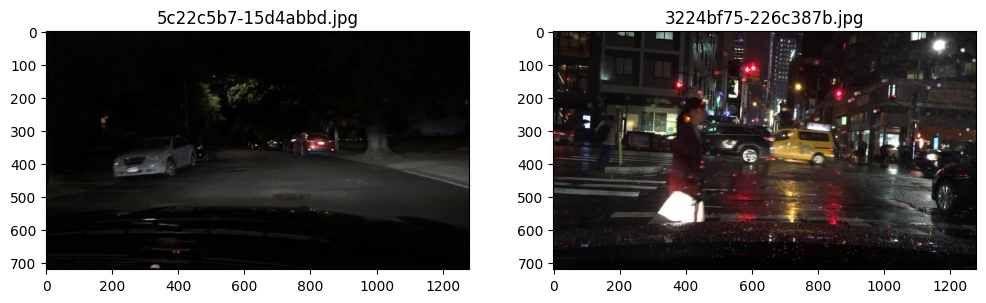

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


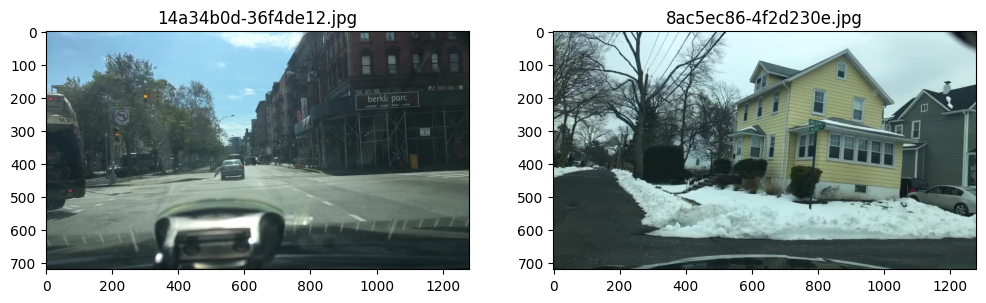

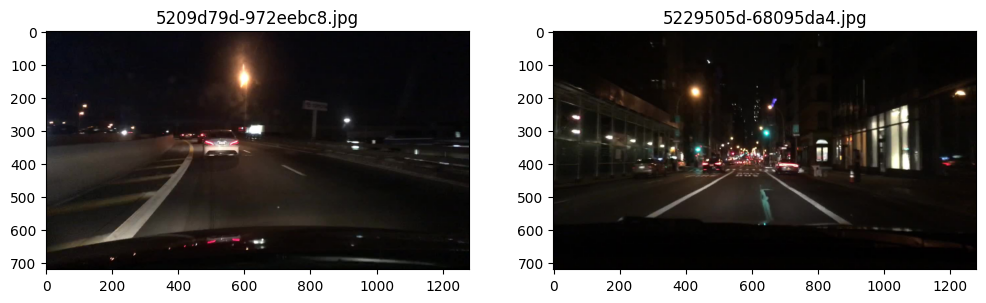

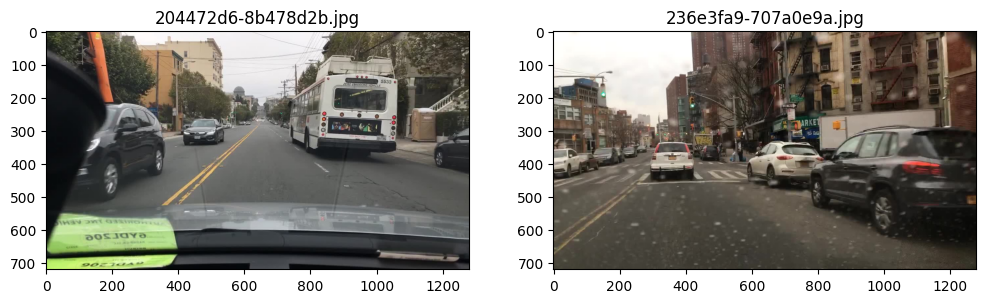

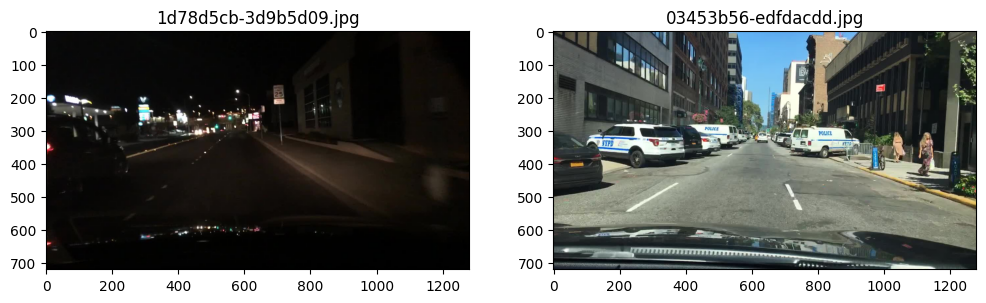

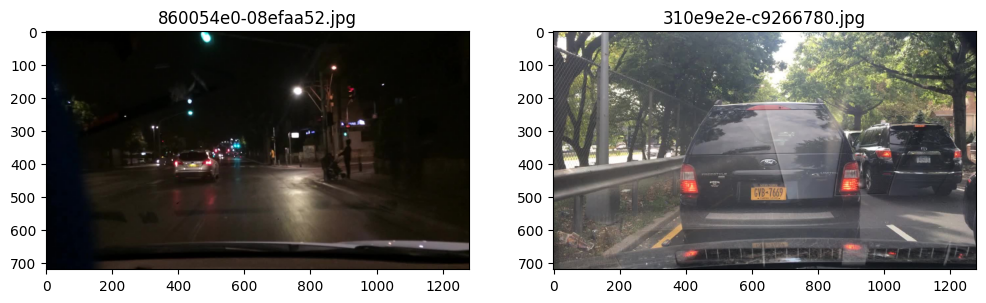

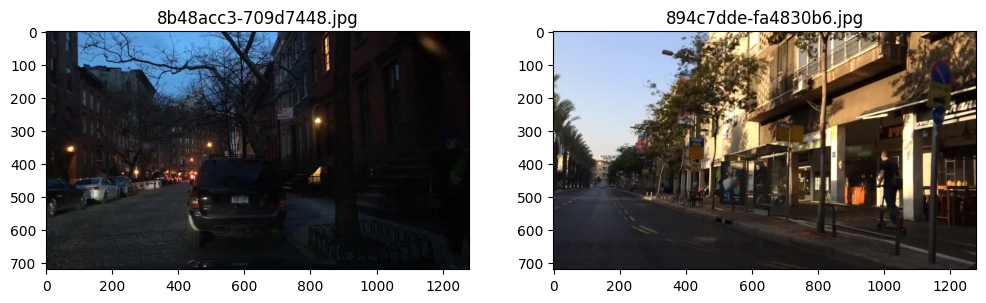

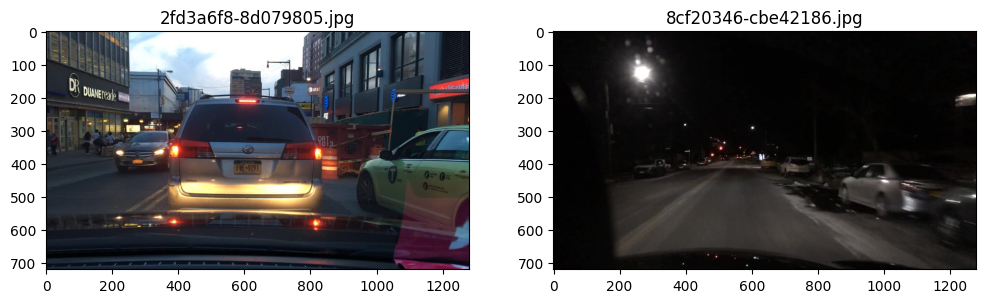

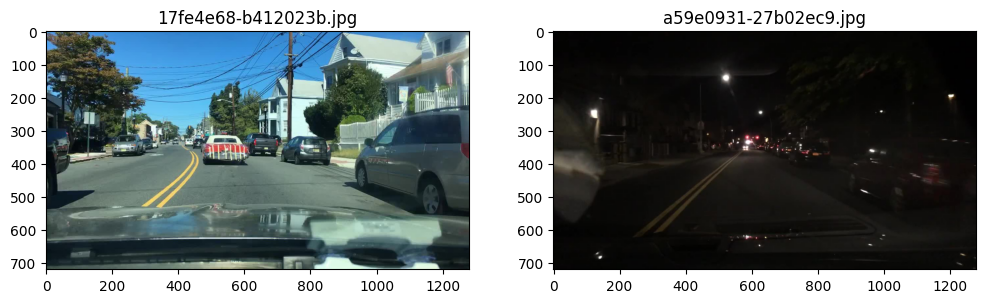

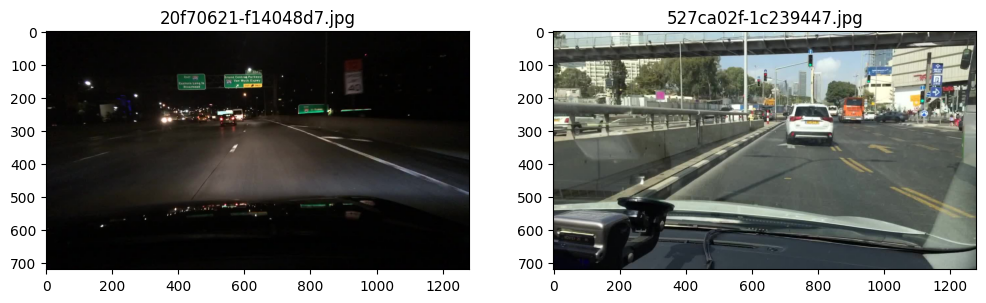

                 Image 1                            Latent Representation 1  \
0  5c22c5b7-15d4abbd.jpg  [[0.6103236, 0.65566283, -1.0446075, -0.046472...   
1  14a34b0d-36f4de12.jpg  [[0.6155119, 0.657022, -1.0555296, -0.04020765...   
2  5209d79d-972eebc8.jpg  [[0.61315215, 0.64635324, -1.034529, -0.042587...   
3  204472d6-8b478d2b.jpg  [[0.61487514, 0.6321852, -1.0948291, -0.022545...   
4  1d78d5cb-3d9b5d09.jpg  [[0.61378753, 0.6549311, -1.0406338, -0.044831...   

                 Image 2                            Latent Representation 2  
0  3224bf75-226c387b.jpg  [[0.61487544, 0.650114, -1.0391968, -0.0455099...  
1  8ac5ec86-4f2d230e.jpg  [[0.6230235, 0.66719973, -1.0769349, -0.037762...  
2  5229505d-68095da4.jpg  [[0.6187889, 0.63989705, -1.0357937, -0.044399...  
3  236e3fa9-707a0e9a.jpg  [[0.6275884, 0.6397608, -1.0514562, -0.0363867...  
4  03453b56-edfdacdd.jpg  [[0.62570757, 0.64444566, -1.0443523, -0.03846...  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
import base64
import torch
from PIL import Image
from transformers import ViTModel, ViTFeatureExtractor
import torchvision.transforms as transforms  # For image augmentation

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CSV data
df = pd.read_csv('/content/image_pairs.csv')

# Image directory
image_dir = '/content/train/images'

# Load a pre-trained Vision Transformer model (using ViT Base)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)  # Move the model to the appropriate device
model.eval()  # Set the model to evaluation mode

# Define image augmentation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

def load_and_preprocess_image(image_path):
    """Load and preprocess the image for the model."""
    with Image.open(image_path) as img:
        img = augmentation(img)  # Apply augmentation
        img = feature_extractor(images=img, return_tensors="pt").to(device)  # Preprocess for ViT and move to GPU
    return img

# List to store latent representations
latent_representations = []

# Display only the first N pairs and extract latent representations
num_pairs_to_display = 10
for index, row in df.iterrows():
    if index >= num_pairs_to_display:
        break  # Stop iterating after displaying the desired number of pairs

    image_1 = row['Image 1']
    image_2 = row['Image 2']

    # Check if images exist in the directory
    image_1_path = os.path.join(image_dir, image_1)
    image_2_path = os.path.join(image_dir, image_2)

    if os.path.exists(image_1_path) and os.path.exists(image_2_path):
        # Display the images
        img1 = plt.imread(image_1_path)
        img2 = plt.imread(image_2_path)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title(image_1)

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title(image_2)

        plt.show()

        # Load and preprocess images
        img1_tensor = load_and_preprocess_image(image_1_path)
        img2_tensor = load_and_preprocess_image(image_2_path)

        # Extract latent representations
        with torch.no_grad():  # Disable gradient calculation
            latent_rep_1 = model(**img1_tensor).last_hidden_state.flatten(start_dim=1).cpu().numpy()  # Extract representation for image 1
            latent_rep_2 = model(**img2_tensor).last_hidden_state.flatten(start_dim=1).cpu().numpy()  # Extract representation for image 2

        # Store the latent representations in a dictionary
        latent_representations.append({
            'Image 1': image_1,
            'Latent Representation 1': latent_rep_1,
            'Image 2': image_2,
            'Latent Representation 2': latent_rep_2,
        })

    else:
        print(f"Image paths not found: {image_1_path}, {image_2_path}")

# Convert the list of latent representations to a DataFrame for further analysis
latent_df = pd.DataFrame(latent_representations)

# Save to a CSV file
latent_df.to_csv('latent_representations_vit.csv', index=False)

# Display the DataFrame
print(latent_df.head())


Fine tuning the vit using self supervised contrastive loss


In [7]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from transformers import ViTModel, ViTFeatureExtractor
import torchvision.transforms as transforms

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CSV data
df = pd.read_csv('/content/image_pairs.csv')

# Image directory
image_dir = '/content/train/images'

# Load a pre-trained Vision Transformer model (using ViT Base)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
model.train()  # Set the model to training mode

# Define image augmentation and resizing
augmentation = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# Define a custom dataset
class ImagePairsDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_1 = self.dataframe.iloc[idx]['Image 1']
        image_2 = self.dataframe.iloc[idx]['Image 2']

        img1_path = os.path.join(self.image_dir, image_1)
        img2_path = os.path.join(self.image_dir, image_2)

        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2

# Create dataset and data loader
dataset = ImagePairsDataset(df, image_dir, transform=augmentation)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features1, features2):
        # Normalize features
        features1 = nn.functional.normalize(features1, dim=-1)
        features2 = nn.functional.normalize(features2, dim=-1)

        # Compute similarity matrix
        similarity_matrix = torch.matmul(features1, features2.T) / self.temperature
        labels = torch.arange(features1.size(0)).to(device)  # Similar pairs

        # Compute contrastive loss
        loss = nn.CrossEntropyLoss()(similarity_matrix, labels)
        return loss

# Initialize loss function and optimizer
contrastive_loss = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# List to store latent features
latent_features = []

# Function to track gradients
def track_gradients(grad):
    print("Gradient:", grad)

# Register hooks to track gradients on model layers
for name, param in model.named_parameters():
    if param.requires_grad:
        param.register_hook(lambda grad: print(f"Gradient for {name}: {grad.norm()}"))

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    for img1, img2 in dataloader:
        img1, img2 = img1.to(device), img2.to(device)

        # Forward pass for image 1
        features1 = model(img1).last_hidden_state.mean(dim=1)

        # Forward pass for image 2
        features2 = model(img2).last_hidden_state.mean(dim=1)

        # Store the extracted features, but detach them from the computational graph
        latent_features.extend(features1.detach().cpu().numpy())
        latent_features.extend(features2.detach().cpu().numpy())

        # Compute loss
        loss = contrastive_loss(features1, features2)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()  # Backpropagation step
        optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Track gradient norms
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Layer: {name}, Gradient Norm: {param.grad.norm()}")

# Save latent features to a CSV file
latent_features_df = pd.DataFrame(latent_features)
latent_features_df.to_csv('latent_features_with_contrastive_loss.csv', index=False)

print("Latent features with contrastive loss saved to 'latent_features_with_contrastive_loss.csv'")

# Save the model after training
torch.save(model.state_dict(), 'fine_tuned_vit_model.pth')


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 7849 has 14.73 GiB memory in use. Of the allocated memory 13.97 GiB is allocated by PyTorch, and 647.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>